In [2]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import backend as K 

In [3]:
folder_benign_train = '/kaggle/input/skin-cancer-malignant-vs-benign/train/benign'
folder_malignant_train = '/kaggle/input/skin-cancer-malignant-vs-benign/train/malignant'

folder_benign_test = '/kaggle/input/skin-cancer-malignant-vs-benign/test/benign'
folder_malignant_test = '/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

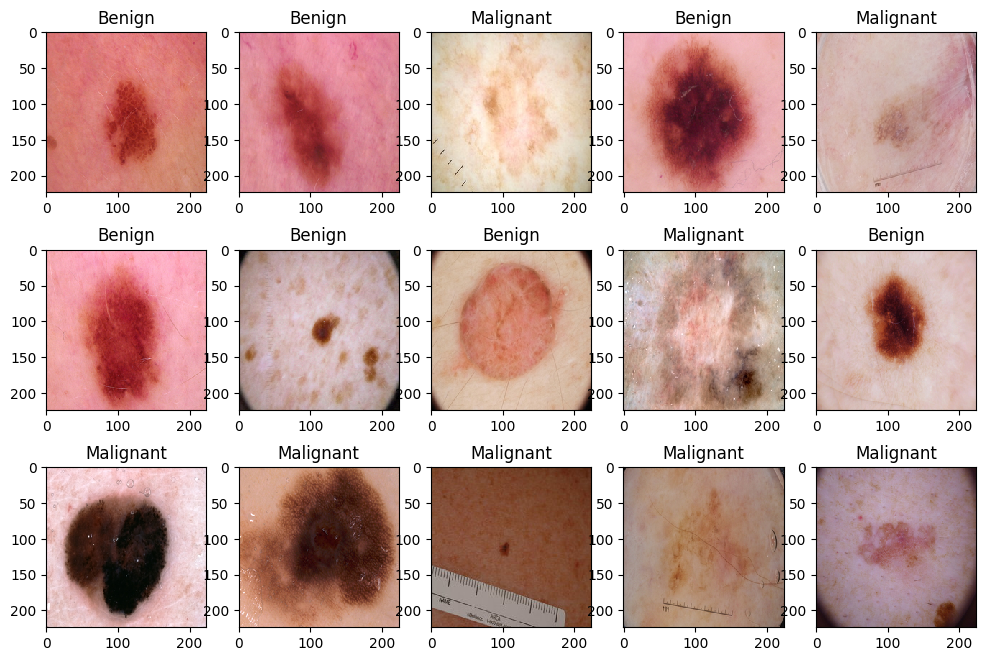

In [4]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [5]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [6]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-9)

Epoch 1/50
33/33 - 19s - loss: 0.8385 - accuracy: 0.5486 - val_loss: 0.6962 - val_accuracy: 0.5360 - lr: 1.0000e-07 - 19s/epoch - 581ms/step
Epoch 2/50
33/33 - 12s - loss: 0.8223 - accuracy: 0.5486 - val_loss: 0.7063 - val_accuracy: 0.5360 - lr: 1.0000e-07 - 12s/epoch - 351ms/step
Epoch 3/50
33/33 - 11s - loss: 0.8130 - accuracy: 0.5486 - val_loss: 0.7231 - val_accuracy: 0.5360 - lr: 1.0000e-07 - 11s/epoch - 339ms/step
Epoch 4/50
33/33 - 11s - loss: 0.8010 - accuracy: 0.5486 - val_loss: 0.7484 - val_accuracy: 0.5360 - lr: 1.0000e-07 - 11s/epoch - 341ms/step
Epoch 5/50
33/33 - 11s - loss: 0.7908 - accuracy: 0.5486 - val_loss: 0.7773 - val_accuracy: 0.5360 - lr: 1.0000e-07 - 11s/epoch - 340ms/step
Epoch 6/50

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.000000058430487e-08.
33/33 - 11s - loss: 0.7835 - accuracy: 0.5491 - val_loss: 0.7967 - val_accuracy: 0.5360 - lr: 1.0000e-07 - 11s/epoch - 340ms/step
Epoch 7/50
33/33 - 12s - loss: 0.7752 - accuracy: 0.5491 - val_loss: 0.7916 -

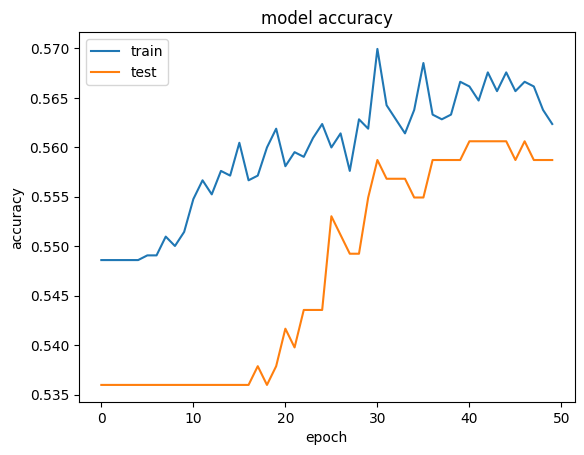

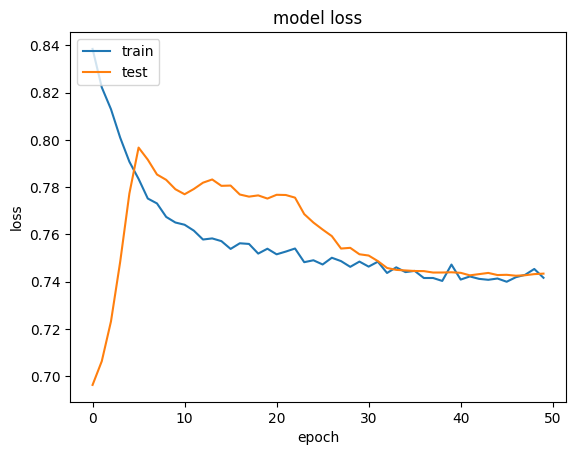

In [11]:
input_shape = (224,224,3)
lr = 1e-7
epochs = 50
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()